# Домашнее задание 1. Autoencoders & Frechet Inception Distance


В этом домашнем задании вам предлагается вспомнить то, что происходило на семинарах 1-2, написать свой автоэнкодер на CIFAR10 и использовать эмбеддинги от этого автоэнкодера чтобы посчитать Frechet Inception Distance (FID) между разными классами в CIFAR10

In [1]:
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import Subset
import matplotlib.pyplot as plt
from tqdm.auto import tqdm, trange
from sklearn.ensemble import GradientBoostingClassifier
from collections import defaultdict
import seaborn as sns

Будем использовать torchvision для работы с данными.

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    lambda x: (x * 2) - 1
])

In [3]:
train_dataset = datasets.CIFAR10(
    './cifar',
    train=True,
    transform=transform,
    download=True)
val_dataset = datasets.CIFAR10(
    './cifar',
    train=False,
    transform=transform,
    download=True)
len(train_dataset), len(val_dataset)

100%|██████████| 170498071/170498071 [00:05<00:00, 29963427.79it/s]


Extracting ./cifar/cifar-10-python.tar.gz to ./cifar
Files already downloaded and verified


(50000, 10000)

Раз мы используем нормализацию картинок, то чтобы их нарисовать - надо их обратно разнормализировать

In [4]:
len(val_dataset)

10000

In [5]:
def denormalize_image(image):
    return (image + 1) / 2

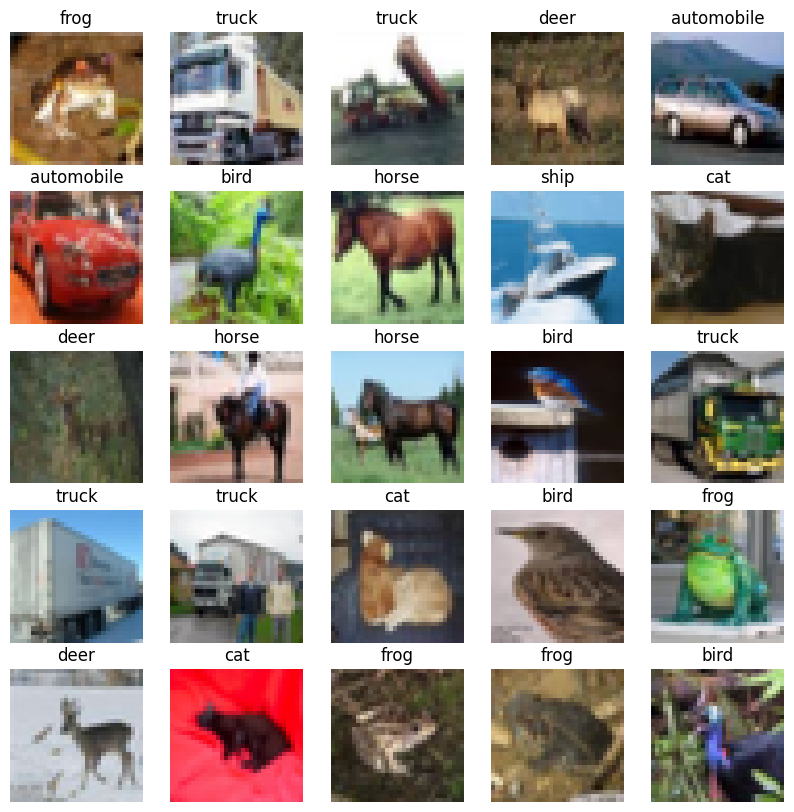

In [6]:
text_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
plt.figure(figsize=(10, 10))
for index, (image, label) in enumerate(train_dataset):
    plt.subplot(5, 5, index + 1)
    plt.imshow(denormalize_image(image.permute(1, 2, 0)))
    plt.axis('off')
    plt.title(text_labels[label])
    if index == 24: break
plt.show()

Размерность картинок: 3 канала 32х32 пикселя

In [7]:
image.shape

torch.Size([3, 32, 32])

In [7]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)
len(train_loader), len(val_loader)

(1563, 10000)

### Задание 1. Обучить AE (3 балла)

Постройте свой AE, можете использовать любые блоки которые вам кажутся необходимыми.

<img src='https://miro.medium.com/max/1400/1*44eDEuZBEsmG_TCAKRI3Kw@2x.png' width=500>

Напишите классы Encoder и Decoder

хинт: вам пригодятся nn.AvgPool2d/nn.MaxPool2d/Conv2d в энкодере и nn.Upsample/nn.ConvTranspose2d в декодере

In [9]:
class Block(nn.Module):

    def __init__(self, in_features, out_features, kernel, stride=1, upsample=False):
      super().__init__()
      self.upsample = None
      if upsample:
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear')
      self.conv = nn.Conv2d(in_channels=in_features, out_channels=out_features, kernel_size=kernel, stride=stride, padding=(kernel-1)//2)
      self.norm = nn.BatchNorm2d(num_features=out_features)
      self.act = nn.LeakyReLU(0.2)

    def forward(self, x):
      if self.upsample is not None:
        x = self.upsample(x)
      return self.act(self.norm(self.conv(x)))


class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        ### BEGIN SOLUTION
        self.out = nn.Sequential(
            Block(3, 8, 3, stride=2), # out : 8, 16, 16
            Block(8, 16, 3, stride=2), # out : 16, 8, 8
            Block(16, 16, 3, stride=1).conv, # out : 16, 8, 8
            nn.MaxPool2d(2),
        )
        ### END SOLUTION

    def forward(self, x):
        ### BEGIN SOLUTION
        return self.out(x)
        ### END SOLUTION

In [11]:
encoder = Encoder()
noise = torch.rand(1, 3, 32, 32) - 1
assert encoder(noise).view(-1).shape[0] < 1*3*32*32

In [13]:
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        ### BEGIN SOLUTION
        self.out = nn.Sequential(
            Block(16, 16, 3, stride=1, upsample=True), # 16 x 8 x 8
            Block(16, 8, 3, stride=1, upsample=True), # 8 x 16 x 16
            Block(8, 3, 3, stride=1, upsample=True), # 3 x 32 x 32
            Block(3, 3, 3, stride=1, upsample=True).conv, # 3 x 32 x 32
        )
        ### END SOLUTION
    def forward(self, x):
        ### BEGIN SOLUTION
        return self.out(x)
        ### END SOLUTION

In [14]:
decoder = Decoder()
noise = torch.rand(1, 3, 32, 32)
emb = encoder(noise)

assert decoder(emb).shape == (1, 3, 32, 32)

Посчитаем скор классификации картинок по эмбеддингам необученного энкодора, и в конце сравним с обученным. Для ускорения расчета, мы используем только часть трейна.

In [15]:
def classification_score(encoder, _train_dataset, val_dataset, device):
    encoder.eval()
    torch.manual_seed(0)
    train_dataset = Subset(_train_dataset, torch.randperm(len(_train_dataset))[:5000])
    X_train = []
    y_train = []
    for image, label in tqdm(train_dataset):
        image = image.to(device)
        with torch.no_grad():
            emb = encoder(image[None, ...])
        X_train.append(emb.cpu().numpy().reshape(-1))
        y_train.append(label)
    X_train = np.stack(X_train)
    y_train = np.stack(y_train)
    clf = GradientBoostingClassifier(n_estimators=50, max_depth=5, verbose=1, random_state=0)
    clf.fit(X_train, y_train)
    X_val = []
    y_val = []
    for image, label in tqdm(val_dataset):
        image = image.to(device)
        with torch.no_grad():
            emb = encoder(image[None, ...])
        X_val.append(emb.cpu().numpy().reshape(-1))
        y_val.append(label)
    X_val = np.stack(X_val)
    y_val = np.stack(y_val)
    return clf.score(X_val, y_val)

In [199]:
classification_score(Encoder(), train_dataset, val_dataset, 'cpu')

  0%|          | 0/5000 [00:00<?, ?it/s]

      Iter       Train Loss   Remaining Time 
         1           2.0985            5.25m
         2           1.9568            5.13m
         3           1.8339            5.03m
         4           1.7342            4.93m
         5           1.6455            4.83m
         6           1.5694            4.72m
         7           1.4987            4.62m
         8           1.4357            4.51m
         9           1.3787            4.41m
        10           1.3229            4.30m
        20           0.9392            3.24m
        30           0.7151            2.16m
        40           0.5717            1.08m
        50           0.4700            0.00s


  0%|          | 0/10000 [00:00<?, ?it/s]

0.39

In [16]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

In [17]:
encoder.to(device)
decoder.to(device);

In [19]:
params = list(encoder.parameters()) + list(decoder.parameters())
optim = torch.optim.AdamW(params)

Напишите функцию train, которая обучает энкодер и декодер на всем трейн сете, возвращает среднюю MSE ошибку

In [20]:
def train(loader, optim, encoder, decoder, device):
    encoder.train()
    decoder.train()
    losses = []
    for image, _ in tqdm(loader, leave=False):
        ### BEGIN SOLUTION
        optim.zero_grad()
        out = decoder(encoder(image.to(device)))
        loss = F.mse_loss(out, image.to(device))
        loss.backward()
        optim.step()
        losses.append(loss.item())
        ### END SOLUTION
    return sum(losses) / len(losses)

In [19]:
loss = train(train_loader, optim, encoder, decoder, device)
assert type(loss) == float
assert 0 < loss < 1
loss

  0%|          | 0/1563 [00:00<?, ?it/s]

0.05972254456939106

Напишите функцию eval, которая возвращает среднюю MSE ошибку по всему валидационному сету

хинт: не забывайте отключать расчет градиентов

In [20]:
def eval(loader, encoder, decoder, device):
    encoder.eval()
    decoder.eval()
    losses = []
    for image, _ in tqdm(loader, leave=False):
        ### BEGIN SOLUTION
        with torch.no_grad():
          out = decoder(encoder(image.to(device)))
          loss = F.mse_loss(out, image.to(device))
          losses.append(loss.item())
        ### END SOLUTION
    return sum(losses) / len(losses)

In [209]:
loss = eval(val_loader, encoder, decoder, device)
assert type(loss) == float
assert 0 < loss < 1
loss

  0%|          | 0/10000 [00:00<?, ?it/s]

0.04512296378491446

Функция full_train возвращает обученный энкодер и декодер. Чтобы пройти ограничения по времени, обучите модель, а затем добавьте загрузку предобученных весов в самое начало функции. Можете использовать шаблон для загрузки весов из Google Drive.

In [21]:
def full_train(device, train_loader, val_loader):
    ### BEGIN SOLUTION


    ### END SOLUTION

    encoder = Encoder().to(device)
    decoder = Decoder().to(device)
    params = list(encoder.parameters()) + list(decoder.parameters())
    optim = torch.optim.AdamW(params)
    train_loss = []
    val_loss = []
    n_epochs = 30
    for e in trange(n_epochs):
        e_train_loss = train(train_loader, optim, encoder, decoder, device)
        train_loss.append(e_train_loss)
        e_val_loss = eval(val_loader, encoder, decoder, device)
        val_loss.append(e_val_loss)
        print(f'Epoch: {e+1}/{n_epochs}')
        print(f'Train MSE loss: {e_train_loss:.4f}')
        print(f'Validation MSE loss: {e_val_loss:.4f}')
    plt.plot(train_loss, label='train')
    plt.plot(val_loss, label='val')
    plt.legend()
    plt.title('MSE Loss')
    plt.show()
    return encoder, decoder

<All keys matched successfully>

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 1/30
Train MSE loss: 0.0655
Validation MSE loss: 0.0456


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 2/30
Train MSE loss: 0.0463
Validation MSE loss: 0.0418


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 3/30
Train MSE loss: 0.0432
Validation MSE loss: 0.0393


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 4/30
Train MSE loss: 0.0418
Validation MSE loss: 0.0391


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 5/30
Train MSE loss: 0.0410
Validation MSE loss: 0.0375


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 6/30
Train MSE loss: 0.0402
Validation MSE loss: 0.0364


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 7/30
Train MSE loss: 0.0396
Validation MSE loss: 0.0361


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 8/30
Train MSE loss: 0.0394
Validation MSE loss: 0.0367


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 9/30
Train MSE loss: 0.0388
Validation MSE loss: 0.0376


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 10/30
Train MSE loss: 0.0383
Validation MSE loss: 0.0362


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 11/30
Train MSE loss: 0.0382
Validation MSE loss: 0.0348


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 12/30
Train MSE loss: 0.0379
Validation MSE loss: 0.0348


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 13/30
Train MSE loss: 0.0375
Validation MSE loss: 0.0341


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 14/30
Train MSE loss: 0.0373
Validation MSE loss: 0.0340


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 15/30
Train MSE loss: 0.0370
Validation MSE loss: 0.0347


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 16/30
Train MSE loss: 0.0369
Validation MSE loss: 0.0335


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 17/30
Train MSE loss: 0.0368
Validation MSE loss: 0.0331


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 18/30
Train MSE loss: 0.0365
Validation MSE loss: 0.0340


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 19/30
Train MSE loss: 0.0364
Validation MSE loss: 0.0331


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 20/30
Train MSE loss: 0.0360
Validation MSE loss: 0.0329


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 21/30
Train MSE loss: 0.0359
Validation MSE loss: 0.0330


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 22/30
Train MSE loss: 0.0358
Validation MSE loss: 0.0336


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 23/30
Train MSE loss: 0.0358
Validation MSE loss: 0.0327


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 24/30
Train MSE loss: 0.0357
Validation MSE loss: 0.0338


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 25/30
Train MSE loss: 0.0356
Validation MSE loss: 0.0322


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 26/30
Train MSE loss: 0.0353
Validation MSE loss: 0.0321


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 27/30
Train MSE loss: 0.0354
Validation MSE loss: 0.0324


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 28/30
Train MSE loss: 0.0353
Validation MSE loss: 0.0323


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 29/30
Train MSE loss: 0.0352
Validation MSE loss: 0.0321


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 30/30
Train MSE loss: 0.0350
Validation MSE loss: 0.0322


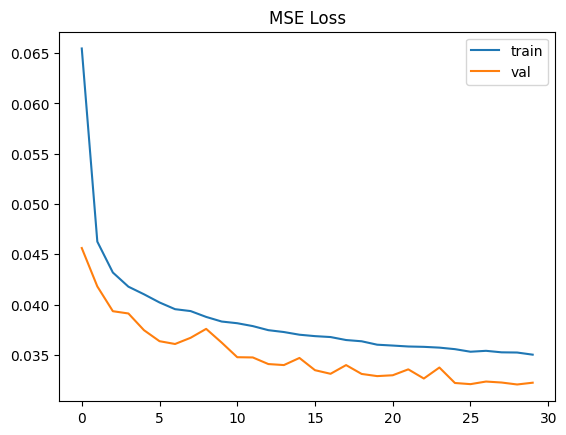

In [22]:
encoder, decoder = full_train(device, train_loader, val_loader)
torch.save(encoder.state_dict(), 'encoder1.pth')
torch.save(decoder.state_dict(), 'decoder1.pth')

In [28]:
encoder = Encoder()
decoder = Decoder()
encoder.load_state_dict(torch.load('/kaggle/input/weights/encoder1.pth', weights_only=True))
decoder.load_state_dict(torch.load('/kaggle/input/weights/decoder1.pth', weights_only=True))
encoder.cuda(device)
decoder.cuda(device)

Decoder(
  (out): Sequential(
    (0): Block(
      (upsample): Upsample(scale_factor=2.0, mode='bilinear')
      (conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (norm): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act): LeakyReLU(negative_slope=0.2)
    )
    (1): Block(
      (upsample): Upsample(scale_factor=2.0, mode='bilinear')
      (conv): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (norm): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act): LeakyReLU(negative_slope=0.2)
    )
    (2): Block(
      (upsample): Upsample(scale_factor=2.0, mode='bilinear')
      (conv): Conv2d(8, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (norm): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act): LeakyReLU(negative_slope=0.2)
    )
    (3): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

In [23]:
score = classification_score(encoder, train_dataset, val_dataset, device)
print(score)
assert score > 0.39
score

  0%|          | 0/5000 [00:00<?, ?it/s]

      Iter       Train Loss   Remaining Time 
         1           2.0845            5.51m
         2           1.9296            5.43m
         3           1.8060            5.31m
         4           1.6987            5.19m
         5           1.6020            5.07m
         6           1.5178            4.96m
         7           1.4441            4.86m
         8           1.3761            4.74m
         9           1.3180            4.63m
        10           1.2605            4.50m
        20           0.8757            3.39m
        30           0.6528            2.27m
        40           0.5057            1.13m
        50           0.4075            0.00s


  0%|          | 0/10000 [00:00<?, ?it/s]

0.4376


0.4376

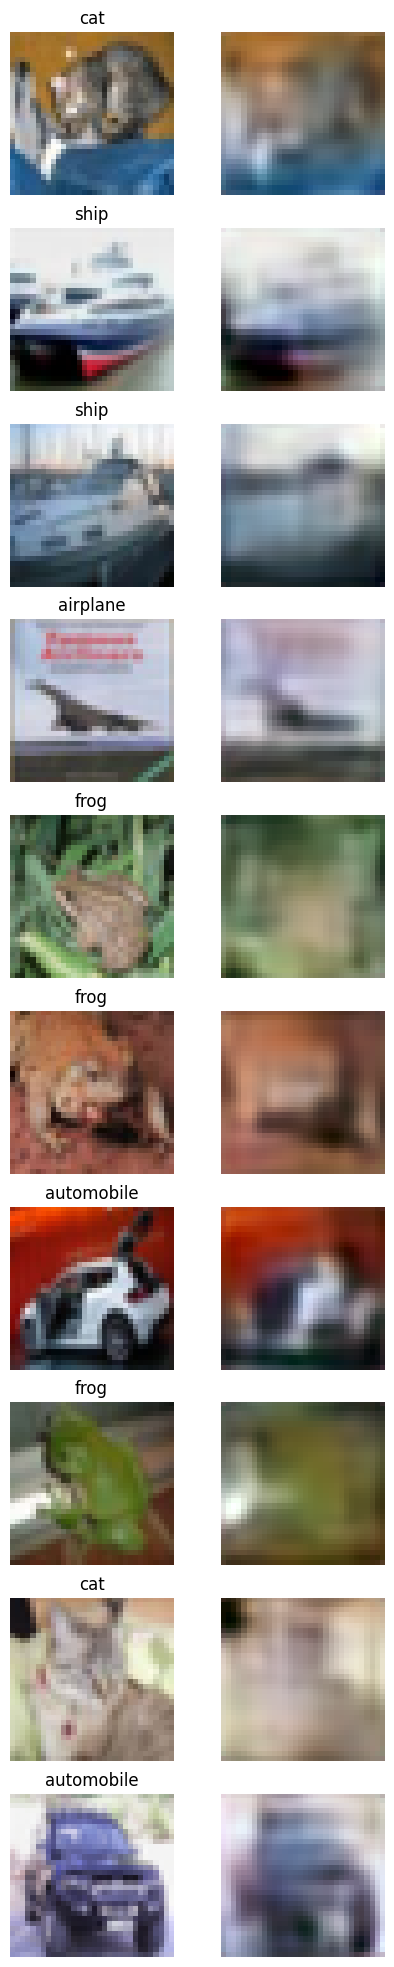

In [29]:
encoder.eval()
decoder.eval()
plt.figure(figsize=(5, 25))
for index, (image, label) in enumerate(val_loader):
    plt.subplot(10, 2, index*2+1)
    plt.imshow(denormalize_image(image)[0].permute(1, 2, 0))
    plt.axis('off')
    plt.title(text_labels[label])
    plt.subplot(10, 2, index*2+2)
    image = image.to(device)
    with torch.no_grad():
        emb = encoder(image)
        rec = decoder(emb).cpu()
    plt.imshow(denormalize_image(rec)[0].permute(1, 2, 0))
    plt.axis('off')
    if index == 9: break

### Задание 2. FID дистанция между классами CIFAR10 (3 балла)

В этой части хочется чтобы вы, используя bottleneck репрезентации от AE обученного в прошлой части посчитали FID дистанцию между различными классами CIFAR10 на **валидационной** выборке

За копию кода из сети будем снимать баллы

Напишите функцию get_representations, которая возвращает defaultdict, где ключ — это номер класса, значение — это список эмбеддингов, полученных из энкодера.

In [30]:
def get_representations(dataloader, encoder, device):
    representations = defaultdict(list)
    for image, label in dataloader:
        image, label = image.to(device), label.to(device)
        representations[label.item()].append(encoder(image).flatten())
    return representations
   

In [35]:
representations = get_representations(val_loader, encoder, device)

assert len(representations) == 10
assert len(representations[0]) == 1000
assert type(representations[0][0]) == torch.Tensor
assert representations[0][0].shape == (256, )

Напишите функцию расчета FID
$$\text{FID}=\left\|\mu_{r}-\mu_{g}\right\|^{2}+T_{r}\left(\Sigma_{r}+\Sigma_{g}-2\left(\Sigma_{r} \Sigma_{g}\right)^{1 / 2}\right)$$

In [62]:
from scipy.linalg import sqrtm

def calculate_fid(repr1, repr2):
    ### BEGIN SOLUTION
    mu1 = repr1.mean(axis=0)
    mu2 = repr2.mean(axis=0)
    difference = mu1 - mu2
    std1 = np.cov(repr1, rowvar=False)
    std2 = np.cov(repr2, rowvar=False)
    sqrt_std = sqrtm(std1.dot(std2))
    if np.iscomplexobj(sqrt_std):
        sqrt_std = sqrt_std.real
    return difference.dot(difference) + np.trace(std1) +np.trace(std2) - np.trace(2 * sqrt_std)
    ### END SOLUTION

In [63]:
heatmap = np.zeros((10, 10))
for label_from in trange(10):
    for label_to in range(10):
        fid = calculate_fid(
            torch.stack(representations[label_from], dim=0).detach().cpu().numpy(),
            torch.stack(representations[label_to], dim=0).detach().cpu().numpy()
        )
        heatmap[label_from, label_to] = fid
assert heatmap.shape == (10, 10)
assert np.all(heatmap + 1e-5 > 0)
airplane_ship = heatmap[0, 8]
airplane_frog = heatmap[0, 6]
truck_automobile = heatmap[9, 1]
truck_dog = heatmap[9, 5]
assert airplane_ship < airplane_frog
assert truck_automobile < truck_dog

  0%|          | 0/10 [00:00<?, ?it/s]

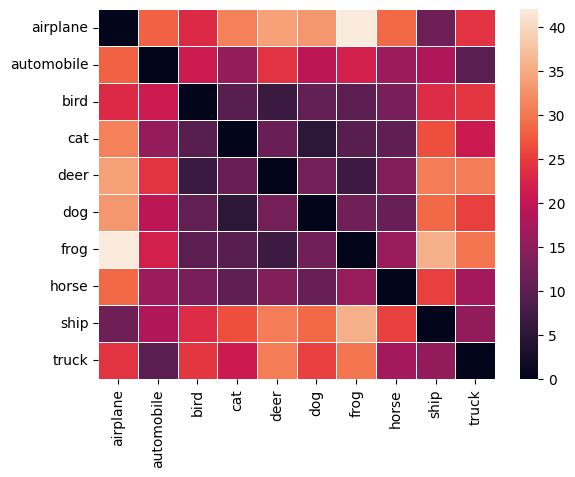

In [64]:
sns.heatmap(
    heatmap,
    linewidth=0.5,
    xticklabels=text_labels,
    yticklabels=text_labels
)
plt.show()